In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
# Define dataset base path
base_path = "/kaggle/input/lte-dataset/Dataset"
categories = ["bus", "car", "pedestrian", "static", "train"]

In [4]:
# List to store DataFrames
dataframes = []

# Loop through each category folder
for category in categories:
    folder_path = os.path.join(base_path, category)
    
    # Get all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Add 'target' column based on folder name
        df['target'] = category
        
        # Append to list
        dataframes.append(df)

In [6]:
# Merge all DataFrames into a single DataFrame
final_df = pd.concat(dataframes, ignore_index=True)
final_df.head()

,Timestamp,Longitude,Latitude,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,...,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance,target
0,2018.01.25_19.50.43,-8.466939,51.897914,46,B,2,LTE,-99,-14,-2.0,...,-82,1688,31,D,-100.0,-17.0,-8.464806,51.891945,679.66999999999996,bus
1,2018.01.25_19.50.44,-8.466616,51.897283,30,B,2,LTE,-99,-14,-1.0,...,-78,1688,31,D,-100.0,-17.0,-8.464806,51.891945,606.40999999999997,bus
2,2018.01.25_19.50.44,-8.466616,51.897283,30,B,2,LTE,-99,-14,-2.0,...,-78,1498,27,D,-100.0,-17.0,-8.464806,51.891945,606.40999999999997,bus
3,2018.01.25_19.50.46,-8.466616,51.897283,30,B,2,LTE,-98,-15,-1.0,...,-81,1286,24,D,-103.0,-18.0,-8.464806,51.891945,606.40999999999997,bus
4,2018.01.25_19.50.47,-8.466616,51.897283,30,B,2,LTE,-98,-15,-1.0,...,-91,548,20,D,-103.0,-18.0,-8.464806,51.891945,606.40999999999997,bus


In [7]:
# Drop unnecessary columns
drop_columns = ["Timestamp", "Operatorname", "NetworkMode", "State"]
final_df = final_df.drop(columns=drop_columns, errors='ignore')

In [9]:
# Apply Label Encoding
label_encoder = LabelEncoder()
final_df['encoded_target'] = label_encoder.fit_transform(final_df['target'])

# Print the mapping of labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
for label, encoded in label_mapping.items():
    print(f"  - {label}: {encoded}")

Label Encoding Mapping:
  - bus: 0
  - car: 1
  - pedestrian: 2
  - static: 3
  - train: 4


In [10]:
# Save merged data to a CSV file
output_path = "/kaggle/working/merged_lte_data.csv"
final_df.to_csv(output_path, index=False)

In [12]:
# Convert object columns to numeric, replacing "-" with NaN
columns_to_convert = ["RSRQ", "SNR", "CQI", "RSSI", "NRxRSRP", "NRxRSRQ", 
                      "ServingCell_Lon", "ServingCell_Lat", "ServingCell_Distance"]

for col in columns_to_convert:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')  # Convert and replace "-" with NaN

In [13]:
# Handle missing values (Replace NaNs with median)
final_df.fillna(final_df.median(numeric_only=True), inplace=True)

In [14]:
# Remove duplicate rows
final_df.drop_duplicates(inplace=True)

In [15]:
# Save cleaned dataset
output_path = "/kaggle/working/cleaned_merged_lte_data.csv"
final_df.to_csv(output_path, index=False)
print(f"\n Preprocessed dataset saved to: {output_path}")


 Preprocessed dataset saved to: /kaggle/working/cleaned_merged_lte_data.csv


In [18]:
# Set the plotting style
sns.set(style="whitegrid")

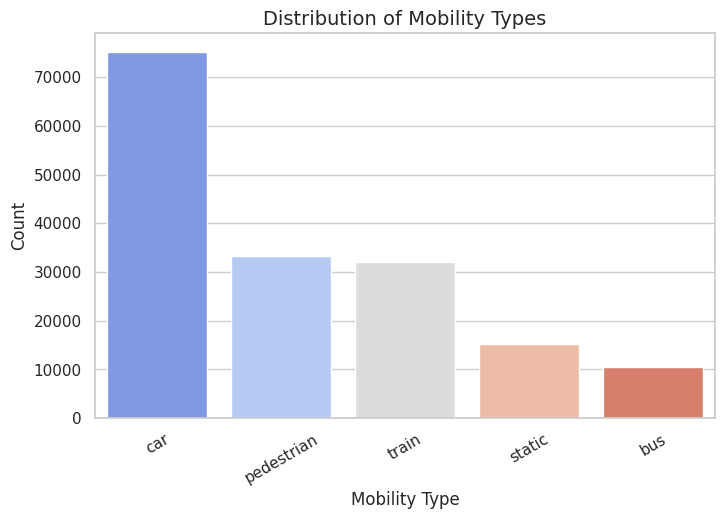

In [19]:
# Distribution of Mobility Types
plt.figure(figsize=(8, 5))
sns.countplot(data=final_df, x="target", palette="coolwarm", order=final_df["target"].value_counts().index)
plt.title("Distribution of Mobility Types", fontsize=14)
plt.xlabel("Mobility Type")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

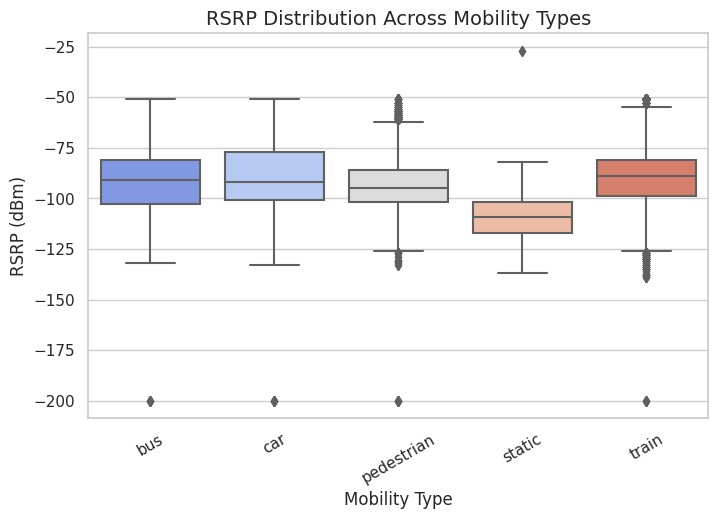

In [20]:
# RSRP Distribution Across Mobility Types
plt.figure(figsize=(8, 5))
sns.boxplot(data=final_df, x="target", y="RSRP", palette="coolwarm")
plt.title("RSRP Distribution Across Mobility Types", fontsize=14)
plt.xlabel("Mobility Type")
plt.ylabel("RSRP (dBm)")
plt.xticks(rotation=30)
plt.show()

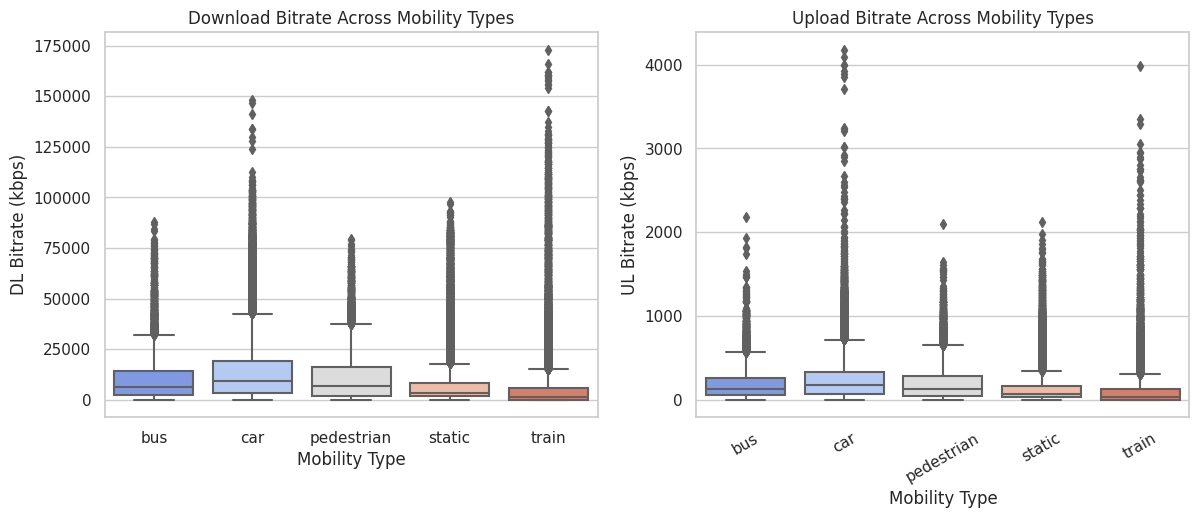

In [21]:
# Download & Upload Bitrate Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=final_df, x="target", y="DL_bitrate", palette="coolwarm", ax=axes[0])
axes[0].set_title("Download Bitrate Across Mobility Types")
axes[0].set_xlabel("Mobility Type")
axes[0].set_ylabel("DL Bitrate (kbps)")

sns.boxplot(data=final_df, x="target", y="UL_bitrate", palette="coolwarm", ax=axes[1])
axes[1].set_title("Upload Bitrate Across Mobility Types")
axes[1].set_xlabel("Mobility Type")
axes[1].set_ylabel("UL Bitrate (kbps)")

plt.xticks(rotation=30)
plt.show()

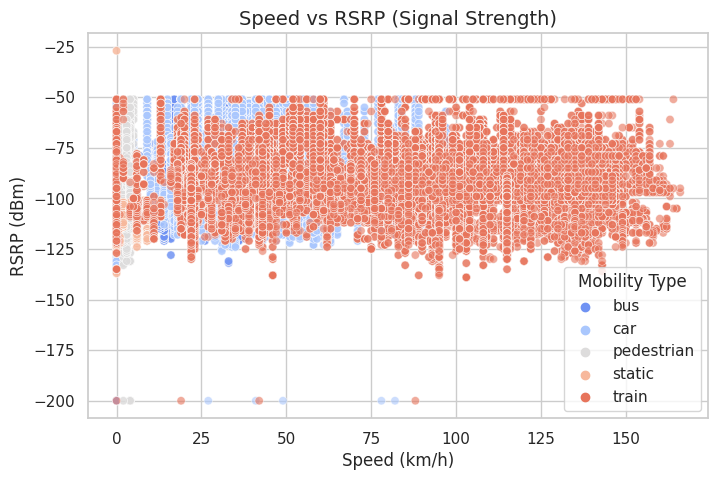

In [22]:
# Scatter Plot: Speed vs RSRP (Signal Strength)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=final_df, x="Speed", y="RSRP", hue="target", alpha=0.6, palette="coolwarm")
plt.title("Speed vs RSRP (Signal Strength)", fontsize=14)
plt.xlabel("Speed (km/h)")
plt.ylabel("RSRP (dBm)")
plt.legend(title="Mobility Type")
plt.show()

In [23]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 166337 entries, 0 to 174521
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Longitude             166337 non-null  float64
 1   Latitude              166337 non-null  float64
 2   Speed                 166337 non-null  int64  
 3   CellID                166337 non-null  int64  
 4   RSRP                  166337 non-null  int64  
 5   RSRQ                  166337 non-null  float64
 6   SNR                   166337 non-null  float64
 7   CQI                   166337 non-null  float64
 8   RSSI                  166337 non-null  float64
 9   DL_bitrate            166337 non-null  int64  
 10  UL_bitrate            166337 non-null  int64  
 11  NRxRSRP               166337 non-null  float64
 12  NRxRSRQ               166337 non-null  float64
 13  ServingCell_Lon       166337 non-null  float64
 14  ServingCell_Lat       166337 non-null  float64
 15  Servi

In [24]:
final_df.columns

Index(['Longitude', 'Latitude', 'Speed', 'CellID', 'RSRP', 'RSRQ', 'SNR',
       'CQI', 'RSSI', 'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
       'ServingCell_Lon', 'ServingCell_Lat', 'ServingCell_Distance', 'target',
       'encoded_target'],
      dtype='object')

In [25]:
final_df.isnull().sum()

Longitude               0
Latitude                0
Speed                   0
CellID                  0
RSRP                    0
RSRQ                    0
SNR                     0
CQI                     0
RSSI                    0
DL_bitrate              0
UL_bitrate              0
NRxRSRP                 0
NRxRSRQ                 0
ServingCell_Lon         0
ServingCell_Lat         0
ServingCell_Distance    0
target                  0
encoded_target          0
dtype: int64

In [27]:
final_df.describe()

,Longitude,Latitude,Speed,CellID,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance,encoded_target
count,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000,166337.000000
mean,-8.460098,51.995072,28.019587,4134.856664,-91.483482,-9.724950,5.256966,8.059957,-80.247846,11328.803231,193.355940,-84.648172,-18.991229,-8.517702,51.934823,4245.880351,1.899734
std,0.386904,0.275722,35.878859,11620.227295,15.860697,5.339664,6.729561,2.524785,8.909536,14280.815674,221.925088,22.329903,3.995606,0.293606,0.164236,13600.822584,1.248156
min,-9.589915,51.871394,0.000000,0.000000,-200.000000,-24.000000,-30.000000,1.000000,-94.000000,0.000000,0.000000,-138.000000,-225.000000,-10.363116,51.468371,25.420000,0.000000
25%,-8.505641,51.893425,0.000000,2.000000,-103.000000,-14.000000,2.000000,7.000000,-85.000000,1755.000000,39.000000,-100.000000,-24.000000,-8.499074,51.893905,592.810000,1.000000
50%,-8.489030,51.898446,12.000000,2.000000,-93.000000,-12.000000,5.000000,8.000000,-81.000000,5927.000000,117.000000,-90.000000,-19.000000,-8.491719,51.895249,758.620000,1.000000
75%,-8.461203,51.930188,44.000000,8.000000,-82.000000,-2.000000,7.000000,9.000000,-78.000000,15456.000000,277.000000,-51.000000,-17.000000,-8.477444,51.903991,1124.440000,3.000000
max,-6.295653,53.346380,166.000000,65353.000000,-27.000000,7.000000,33.000000,15.000000,-36.000000,173016.000000,4178.000000,0.000000,-2.000000,-6.131912,53.613701,222739.980000,4.000000


In [2]:
# Ensure GPU usage on Kaggle
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Load the dataset
df = pd.read_csv("Dataset\cleaned_merged_lte_data.csv")

# Features and Target
features = ["Longitude", "Latitude", "Speed", "RSRP", "RSRQ", "SNR", "CQI", "RSSI", "DL_bitrate", "UL_bitrate", "NRxRSRP", "NRxRSRQ", "ServingCell_Distance"]
target_col = "encoded_target"

X = df[features].values
y = df[target_col].values

# Standard Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for future use
with open("standard_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
# Ensure GPU usage if available
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Load the dataset
df = pd.read_csv("Dataset/cleaned_merged_lte_data.csv")

In [ ]:
# Features and Target
features = ["Longitude", "Latitude", "Speed", "RSRP", "RSRQ", "SNR", "CQI", "RSSI", "DL_bitrate", "UL_bitrate", "NRxRSRP", "NRxRSRQ", "ServingCell_Distance"]
target_col = "encoded_target"

In [ ]:
X = df[features].values
y = df[target_col].values

In [ ]:
# Standard Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for future use
with open("standard_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
# Create Graph Data (Reducing Memory Usage with Approximate Nearest Neighbors)
num_neighbors = 5  # Further reduce the number of neighbors to save memory
nbrs = NearestNeighbors(n_neighbors=num_neighbors, algorithm='kd_tree').fit(X_scaled)
adjacency_matrix = nbrs.kneighbors_graph(X_scaled, mode='connectivity')

edges = np.vstack(adjacency_matrix.nonzero())  # Convert sparse to index-based edge list
nodes = torch.tensor(X_scaled, dtype=torch.float).to(device)
edges = torch.tensor(edges, dtype=torch.long).to(device)
targets = torch.tensor(y, dtype=torch.long).to(device)

data = Data(x=nodes, edge_index=edges, y=targets).to(device)

In [ ]:
def create_train_test_split(data, train_ratio=0.8):
    num_nodes = data.x.shape[0]
    train_size = int(train_ratio * num_nodes)
    perm = torch.randperm(num_nodes, device=device)
    train_idx = perm[:train_size]
    test_idx = perm[train_size:]
    return train_idx, test_idx

train_idx, test_idx = create_train_test_split(data)

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool, device=device)
data.train_mask[train_idx] = True

data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool, device=device)
data.test_mask[test_idx] = True

In [ ]:
# Define Improved Graph Neural Network Model
class GNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GNNModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.conv3 = GATConv(hidden_dim, output_dim)
        self.dropout = dropout
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Model Initialization
input_dim = len(features)
hidden_dim = 128  # Increased for better learning
output_dim = len(np.unique(y))
model = GNNModel(input_dim, hidden_dim, output_dim).to(device)

# Training Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

# Train the model
num_epochs = 200
best_acc = 0.0
for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    loss = train()
    acc = test()
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_gnn_model.pth")
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}, Best Accuracy: {best_acc:.4f}")

Using device: cpu
Epoch 1, Loss: 1.7032, Test Accuracy: 0.5065, Best Accuracy: 0.5065
Epoch 2, Loss: 1.4017, Test Accuracy: 0.5329, Best Accuracy: 0.5329
Epoch 3, Loss: 1.2598, Test Accuracy: 0.5644, Best Accuracy: 0.5644
Epoch 4, Loss: 1.1705, Test Accuracy: 0.6058, Best Accuracy: 0.6058
Epoch 5, Loss: 1.0990, Test Accuracy: 0.6597, Best Accuracy: 0.6597
Epoch 6, Loss: 1.0408, Test Accuracy: 0.6870, Best Accuracy: 0.6870
Epoch 7, Loss: 0.9918, Test Accuracy: 0.7033, Best Accuracy: 0.7033
Epoch 8, Loss: 0.9485, Test Accuracy: 0.7250, Best Accuracy: 0.7250
Epoch 9, Loss: 0.9083, Test Accuracy: 0.7305, Best Accuracy: 0.7305
Epoch 10, Loss: 0.8725, Test Accuracy: 0.7295, Best Accuracy: 0.7305
Epoch 11, Loss: 0.8413, Test Accuracy: 0.7322, Best Accuracy: 0.7322
Epoch 12, Loss: 0.8130, Test Accuracy: 0.7395, Best Accuracy: 0.7395
Epoch 13, Loss: 0.7868, Test Accuracy: 0.7484, Best Accuracy: 0.7484
Epoch 14, Loss: 0.7568, Test Accuracy: 0.7534, Best Accuracy: 0.7534
Epoch 15, Loss: 0.7358, T

In [ ]:
# Save the trained model
model_path = "gnn_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")